In [25]:
# Import essential libraries for data manipulation
import pandas as pd   # For working with dataframes and structured data
import numpy as np    # For numerical operations and array manipulations

# Import visualization libraries
import matplotlib.pyplot as plt   # For creating static visualizations
import seaborn as sns             # For statistical data visualizations (built on top of matplotlib)

# Import libraries for building machine learning models
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler,  FunctionTransformer     # For scaling numerical features to standard normal distribution
from sklearn.ensemble import RandomForestClassifier    # Ensemble learning classifier using random forests
from sklearn.linear_model import LogisticRegression    # Logistic Regression model for classification tasks
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve  
# Metrics to evaluate model performance:
# - confusion_matrix: basic prediction performance
# - classification_report: precision, recall, F1-score
# - roc_auc_score: Area under the ROC curve
# - roc_curve: Curve that shows the tradeoff between true positive rate and false positive rate

# Pipeline tools for streamlining preprocessing and modeling
from imblearn.pipeline import Pipeline   # Allows chaining preprocessing and modeling steps into a single object
from sklearn.compose import ColumnTransformer  # Allows applying different transformations to different columns
from sklearn.preprocessing import OneHotEncoder # Encodes categorical features into a one-hot numeric array

# Suppress warnings to keep output clean
import warnings 
warnings.filterwarnings('ignore')  # Ignores all warnings (use with care in production)


In [2]:
# importing dataset 

df = pd.read_csv('../Data/Cleaned/cleaned_data.csv')



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Preprocessing

* Drop identifiers: nameOrig, nameDest (not useful for prediction).
  

In [4]:
df =df.drop(['nameOrig','nameDest','isFlaggedFraud'] , axis= 1)
df.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


* features and target 

In [5]:
X = df.drop('isFraud' , axis= 1 )
y= df['isFraud']

*  Identify categorical & numerical features

In [6]:
categorical = ['type']
numerical = [col for col in X.columns if col not in categorical]

* Train-test split

In [7]:
X_train , X_test , y_train , y_test = train_test_split(X ,y , train_size=0.3 , random_state= 42 , stratify=y)

* Preprocessor (scale numeric, encode categorical)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)



# Logistic Regression Pipeline

* Build pipeline:

In [9]:
log_reg_pipeline = Pipeline(steps=[
                           ('Preprocessor' ,preprocessor),
                            ('classifier' , LogisticRegression(max_iter=1000 , class_weight= 'balanced')
                            )]
                           )



#  Training and Evaluating model

In [10]:
# training model 

log_reg_pipeline.fit(X_train , y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [11]:
# Evaluate
y_pred = log_reg_pipeline.predict(X_test)
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

In [12]:
print(classification_report(y_test , y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98   4448085
           1       0.02      0.95      0.05      5738

    accuracy                           0.95   4453823
   macro avg       0.51      0.95      0.51   4453823
weighted avg       1.00      0.95      0.97   4453823

ROC-AUC: 0.9897696535688048


### Class 0 (Not Fraud)

- **Precision = 1.00** → Almost every time the model predicts *not fraud*, it’s correct.
- **Recall = 0.95** → It correctly identifies 95% of the *not fraud* cases.
- **F1 = 0.98** → Excellent performance on the majority class.

### Class 1 (Fraud)

- **Precision = 0.02** → When the model predicts fraud, only **2% are truly frauds** → **lots of false positives**.
- **Recall = 0.95** → It catches **95% of all fraud cases** → amazing recall.
- **F1 = 0.05** → Because precision is terrible, the F1 is very low.

### Overall

- **Accuracy = 0.95** → Looks good, but misleading (dataset is imbalanced).
- **Macro avg** shows the balance between classes → low precision drags it down.

- The model is **very aggressive in flagging fraud** (high recall).
- But it’s doing this by marking **tons of normal transactions as fraud** (precision = 0.02).
- This is common in **imbalanced datasets** (fraud detection, medical diagnosis, etc.).

In [13]:
from sklearn.metrics import precision_score, recall_score

# Try threshold = 0.5, 0.3, 0.2...
thresholds = [0.5, 0.3, 0.2, 0.1]
for t in thresholds:
    y_pred_custom = (y_prob >= t).astype(int)
    print(f"Threshold={t}")
    print("Precision:", precision_score(y_test, y_pred_custom))
    print("Recall:", recall_score(y_test, y_pred_custom))
    print()

Threshold=0.5
Precision: 0.02469414473387206
Recall: 0.9532938306029975

Threshold=0.3
Precision: 0.012191086087591868
Recall: 0.9886720111537121

Threshold=0.2
Precision: 0.008610253410775738
Recall: 0.9928546531892646

Threshold=0.1
Precision: 0.006039668363833605
Recall: 0.99355176019519



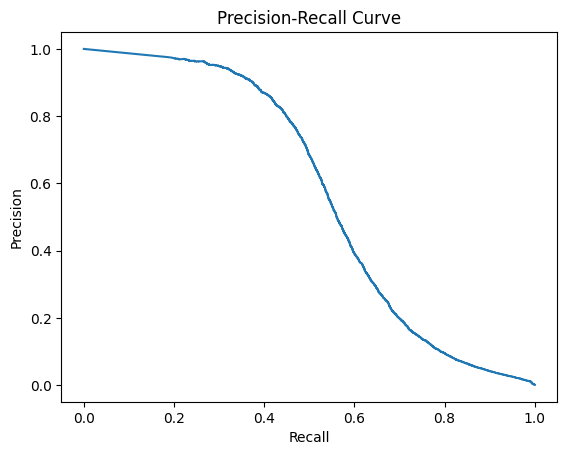

In [14]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


- At **lower thresholds**: model flags *more* transactions as fraud → recall ↑ but precision ↓.
- At **higher thresholds**: model flags *fewer* frauds → precision ↑ but recall ↓.
- Right now, Logistic Regression **cannot achieve good precision** → it’s drowning in false positives.

# Improving the logesticRegression model 

lets try make the logestical regression work 

## Resampling the dataset and feature engineering 

# feature engineering function 

In [32]:
def feature_engineering(X):
    X=X.copy()
    X['diffOrig'] = X['oldbalanceOrg'] - X['newbalanceOrig']
    X['diffDest'] = X['newbalanceDest'] - X['oldbalanceDest']
    X['amt_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1)
    return X

# Apply to dataset
df = pd.read_csv("../Data/Cleaned/cleaned_data.csv")
df = df.drop(['nameOrig', 'nameDest'], axis=1)

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Columns
categorical = ['type']
numerical = [col for col in X.columns if col not in categorical]

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num' , StandardScaler() , numerical + ['diffOrig' , 'diffDest' , 'amt_ratio']),
        ('cat' , OneHotEncoder(drop='first') , categorical )
    ]
)

## Full pipeline: FE + SMOTE + Logistic Regression

In [34]:
pipeline = Pipeline(steps=[
    ('fe', FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),   # now valid inside imblearn's Pipeline
    ('classifier', LogisticRegression(max_iter=1000))
])

## Train the model

In [35]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('fe',
                 FunctionTransformer(func=<function feature_engineering at 0x0000028E201F5300>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest', 'diffOrig',
                                                   'diffDest', 'amt_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

## Evaluate

In [36]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906323
           1       0.02      0.95      0.05      2459

    accuracy                           0.95   1908782
   macro avg       0.51      0.95      0.51   1908782
weighted avg       1.00      0.95      0.97   1908782

ROC-AUC: 0.9891224533701186


## SMOTE didn’t help much with Logistic Regression here

1. **Logistic Regression is too simple**
    - Even with more synthetic frauds, it can’t separate fraud vs. non-fraud well in this dataset.
    - Fraud patterns are usually **non-linear** (complex rules, interactions). Logistic Regression is linear.
2. **Extreme imbalance**
    - Fraud is *so rare* that even oversampling to balance can’t fix precision.
    - The model still ends up flagging a huge number of normal transactions as fraud.
3. **Feature space may still be weak**
    - The features we added (`diffOrig`, `diffDest`, `amt_ratio`) help, but more domain-specific features might be needed.

In the next notebook we are going to try a tree based model :RandomForestClassifier 